In [2]:
import os
import sys
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("YourAppName")  \
    .config("spark.executor.memory", "6g") \
    .config("spark.executor.cores", "2") \
    .getOrCreate()

commission_df = spark.read.parquet(os.path.join("../data/curated/cleaned_profit_per_merchants", "*.parquet"))
commission_df.show(2)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/07 15:29:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+------------+-----------------------------+
|merchant_abn|predict_6_months_total_profit|
+------------+-----------------------------+
| 10255988167|                    4401.4478|
| 10430380319|                     1007.187|
+------------+-----------------------------+
only showing top 2 rows



In [3]:
fraud_df = spark.read.parquet("../data/curated/merchant_fraud_all.parquet")
fraud_df.show(2)

+------------+----------------------+
|merchant_abn|mean_fraud_probability|
+------------+----------------------+
| 21439773999|     32.53321204787232|
| 10165489824|    59.715004920401555|
+------------+----------------------+
only showing top 2 rows



In [4]:
clusters_df = spark.read.parquet(os.path.join("../data/curated/merchant_clusters", "*.parquet"))
clusters_df.show(2)

+------------+-------------------+
|merchant_abn|            cluster|
+------------+-------------------+
| 88218638184|Leisure and Hobbies|
| 88230622213|IT and Tech Gadgets|
+------------+-------------------+
only showing top 2 rows



In [5]:
abs_df = spark.read.parquet(os.path.join("../data/curated/merchant_abs_related", "*.parquet"))
abs_df.show(2)

+------------+--------+----------+-----------------+----------+-------------------+
|merchant_abn|num_user|num_region|    median_income|total_rows|returned_user_ratio|
+------------+--------+----------+-----------------+----------+-------------------+
| 12516851436|     210|       157|816.2857142857143|       210|                1.0|
| 15613631617|    1714|       777|799.5350140056022|      1785| 1.0414235705950992|
+------------+--------+----------+-----------------+----------+-------------------+
only showing top 2 rows



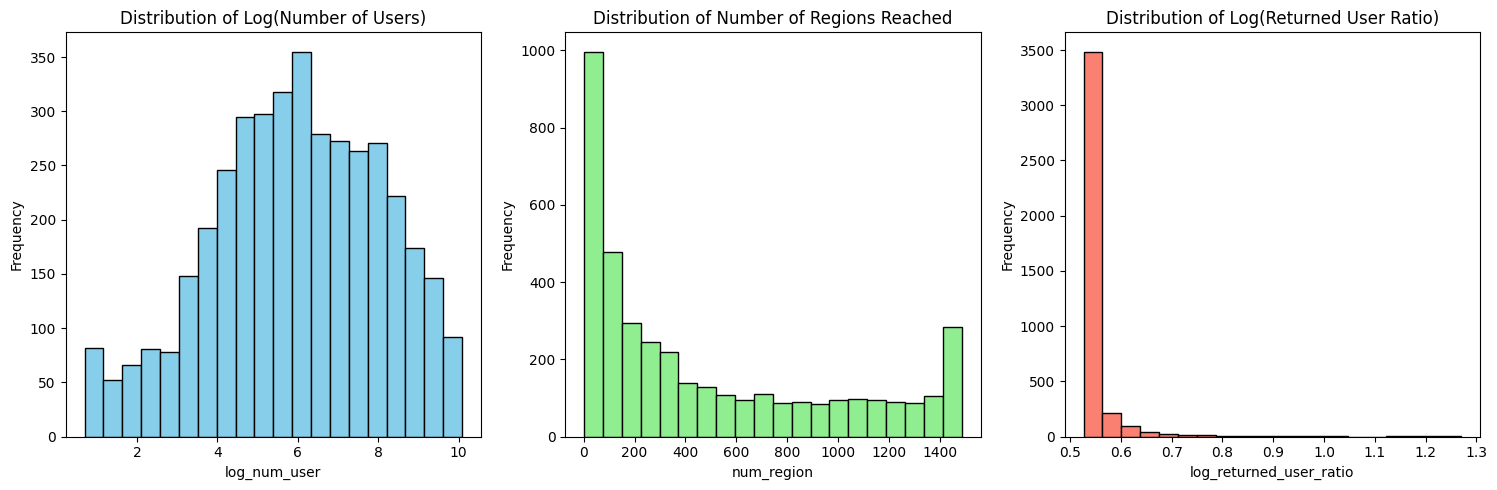

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Convert the abs_df PySpark DataFrame to a Pandas DataFrame for plotting
abs_df_pd = abs_df.toPandas()

# Avoid log(0) by replacing zeros with a very small value before applying log
abs_df_pd['log_num_user'] = np.log1p(abs_df_pd['num_user'])  # log1p(x) = log(1 + x), works for 0
abs_df_pd['log_returned_user_ratio'] = np.log1p(np.log1p(abs_df_pd['returned_user_ratio']))

# Plot the distributions
plt.figure(figsize=(15, 5))

# Plot the distribution of log(num_user)
plt.subplot(1, 3, 1)
plt.hist(abs_df_pd['log_num_user'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Log(Number of Users)')
plt.xlabel('log_num_user')
plt.ylabel('Frequency')

# Plot the distribution of 'num_region'
plt.subplot(1, 3, 2)
plt.hist(abs_df_pd['num_region'], bins=20, color='lightgreen', edgecolor='black')
plt.title('Distribution of Number of Regions Reached')
plt.xlabel('num_region')
plt.ylabel('Frequency')

# Plot the distribution of log(returned_user_ratio)
plt.subplot(1, 3, 3)
plt.hist(abs_df_pd['log_returned_user_ratio'], bins=20, color='salmon', edgecolor='black')
plt.title('Distribution of Log(Returned User Ratio)')
plt.xlabel('log_returned_user_ratio')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [7]:
transactions = spark.read.parquet("../data/curated/curated_transaction")
transactions.show(2)

+-------+------------+------------------+--------------------+--------------+-----------------+
|user_id|merchant_abn|      dollar_value|            order_id|order_datetime| log_dollar_value|
+-------+------------+------------------+--------------------+--------------+-----------------+
|  14935| 79417999332|136.06570809815838|23acbb7b-cf98-458...|    2021-11-26| 4.91313791683832|
|      1| 46451548968| 72.61581642788431|76bab304-fa2d-400...|    2021-11-26|4.285182755236724|
+-------+------------+------------------+--------------------+--------------+-----------------+
only showing top 2 rows



In [8]:
from pyspark.sql import functions as F

transactions = transactions.groupBy('merchant_abn').agg(
    F.sum('dollar_value').alias('total_dollar')
)

transactions.show(2)

+------------+------------------+
|merchant_abn|      total_dollar|
+------------+------------------+
| 83412691377|498462.05400725023|
| 35344855546| 134733.1219268962|
+------------+------------------+
only showing top 2 rows



24/10/07 15:30:01 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


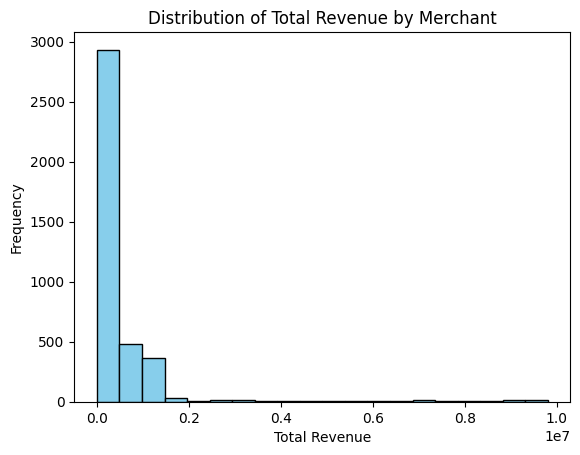

In [9]:
# Convert the PySpark DataFrame to Pandas
transactions_pd = transactions.toPandas()

# Plot the distribution of 'total_dollar'
plt.hist(transactions_pd['total_dollar'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Total Revenue by Merchant')
plt.xlabel('Total Revenue')
plt.ylabel('Frequency')
plt.show()

In [10]:
# Perform inner joins of the DataFrames on 'merchant_abn'
final_df = commission_df.join(fraud_df, on='merchant_abn', how='inner') \
    .join(clusters_df, on='merchant_abn', how='inner') \
    .join(abs_df, on='merchant_abn', how='inner') \
    .join(transactions, on='merchant_abn', how='inner')

final_df = final_df.withColumnRenamed('predict_6_months_total_profit', 'predicted_commission')
final_df = final_df.withColumnRenamed('returned_user_ratio', 'returned_rate')
final_df = final_df.withColumnRenamed('total_dollar', 'merchant_revenue')
final_df = final_df.withColumnRenamed('mean_fraud_probability', 'fraud')
final_df = final_df.withColumnRenamed('cluster', 'business')
final_df = final_df.drop("total_rows")

In [11]:
# Show the resulting DataFrame
final_df.show(2, vertical = True)

-RECORD 0------------------------------------
 merchant_abn         | 12516851436          
 predicted_commission | 788.317              
 fraud                | 64.77377242516687    
 business             | Accessories and L... 
 num_user             | 210                  
 num_region           | 157                  
 median_income        | 816.2857142857143    
 returned_rate        | 1.0                  
 merchant_revenue     | 32325.484349738053   
-RECORD 1------------------------------------
 merchant_abn         | 37935728745          
 predicted_commission | -9.032302            
 fraud                | 60.55813283786244    
 business             | Art and Decors       
 num_user             | 2                    
 num_region           | 2                    
 median_income        | 674.5                
 returned_rate        | 1.0                  
 merchant_revenue     | 3070.906279851508    
only showing top 2 rows



In [12]:
final_df.count()

2927

In [14]:
from pyspark.sql import functions as F

# Group by 'business' and calculate the sum of 'predicted_commission' for each business type
business_commission_sum = final_df.groupBy('business').agg(
    F.sum('predicted_commission').alias('total_predicted_commission')
)

# Calculate the total predicted commission across all rows
total_commission = final_df.agg(F.sum('predicted_commission')).collect()[0][0]

# Calculate the percentage of predicted commission for each business type
business_percentage_commission = business_commission_sum.withColumn(
    'percentage_of_total_commission', (F.col('total_predicted_commission') / total_commission) * 100
)

business_percentage_commission.show()

+--------------------+--------------------------+------------------------------+
|            business|total_predicted_commission|percentage_of_total_commission|
+--------------------+--------------------------+------------------------------+
|Housing Appliance...|        2767397.9498548806|            13.088284965752225|
|      Art and Decors|          6628647.54646945|             31.34989242522058|
| IT and Tech Gadgets|         4798251.968975067|            22.693118317414594|
|Accessories and L...|          2665540.12679404|            12.606552942252911|
| Leisure and Hobbies|          4284246.27448082|            20.262151349359687|
+--------------------+--------------------------+------------------------------+



In [15]:
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.functions import vector_to_array  # Correct import for vector_to_array
from pyspark.sql import functions as F

# Assemble the columns into a single feature vector, excluding 'merchant_abn' and 'business'
assembler = VectorAssembler(inputCols=[
    'predicted_commission', 'fraud', 'num_user', 'num_region', 
    'median_income', 'returned_rate', 'merchant_revenue'
], outputCol='features')

# Apply MinMaxScaler to the assembled feature vector
scaler = MinMaxScaler(inputCol='features', outputCol='scaled_features')

# Create a pipeline to assemble and scale
pipeline = Pipeline(stages=[assembler, scaler])

# Fit the pipeline to the data and transform
pipeline_model = pipeline.fit(final_df)
scaled_df = pipeline_model.transform(final_df)

# Convert the scaled_features vector to an array so we can access individual elements
scaled_df = scaled_df.withColumn('scaled_features_array', vector_to_array('scaled_features'))

# Split the scaled features array back into individual columns
scaled_columns = ['scaled_predicted_commission', 'scaled_fraud', 'scaled_num_user', 'scaled_num_region', 
                  'scaled_median_income', 'scaled_returned_rate', 'scaled_merchant_revenue']

for i, col in enumerate(scaled_columns):
    scaled_df = scaled_df.withColumn(col, scaled_df['scaled_features_array'][i])

# Select the original columns plus the scaled columns
final_df = scaled_df.select('merchant_abn', 'business', *scaled_columns)

# Show the resulting DataFrame
final_df.show(1, vertical=True)

-RECORD 0-------------------------------------------
 merchant_abn                | 12516851436          
 business                    | Accessories and L... 
 scaled_predicted_commission | 0.06618363268699917  
 scaled_fraud                | 0.8744734599364518   
 scaled_num_user             | 0.008679401993355483 
 scaled_num_region           | 0.10497981157469717  
 scaled_median_income        | 0.2535841382816472   
 scaled_returned_rate        | 0.0                  
 scaled_merchant_revenue     | 0.003289032727595... 
only showing top 1 row



In [16]:
# Flip the 'scaled_fraud' value by subtracting it from 1
final_df = final_df.withColumn('scaled_fraud', 1 - F.col('scaled_fraud'))

# Show the resulting DataFrame
final_df.show(1, vertical=True)

-RECORD 0-------------------------------------------
 merchant_abn                | 12516851436          
 business                    | Accessories and L... 
 scaled_predicted_commission | 0.06618363268699917  
 scaled_fraud                | 0.12552654006354824  
 scaled_num_user             | 0.008679401993355483 
 scaled_num_region           | 0.10497981157469717  
 scaled_median_income        | 0.2535841382816472   
 scaled_returned_rate        | 0.0                  
 scaled_merchant_revenue     | 0.003289032727595... 
only showing top 1 row



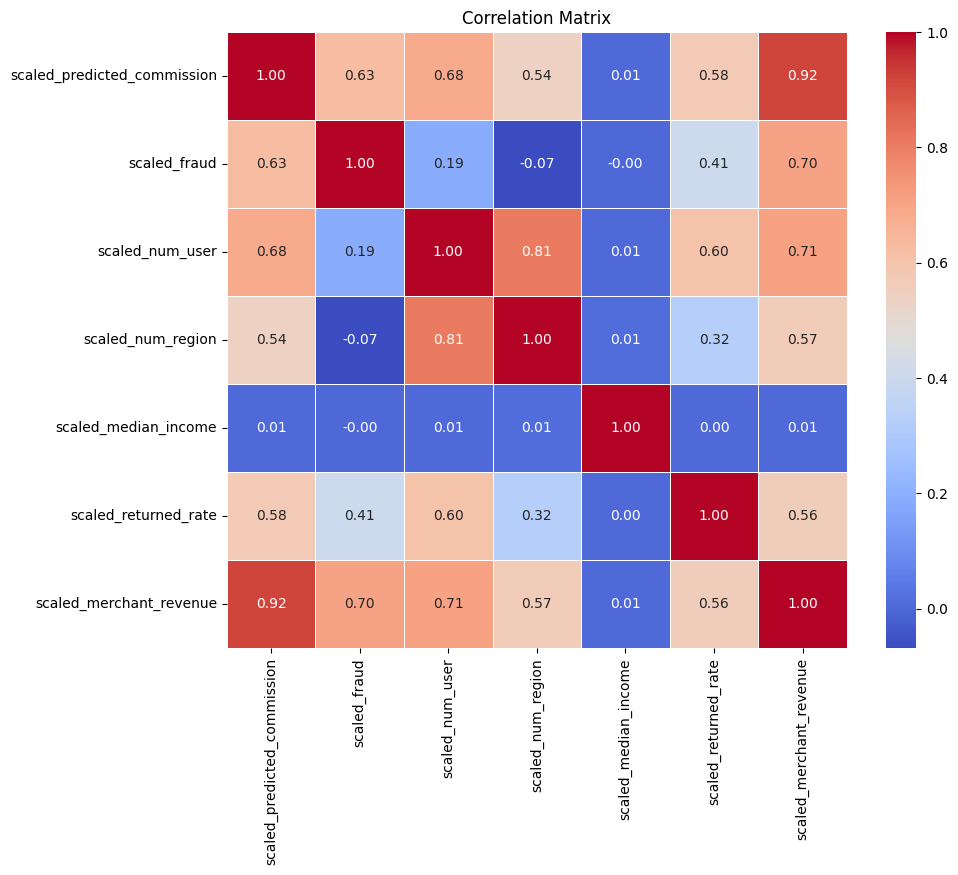

In [17]:
import seaborn as sns

# Select the numerical columns for correlation (excluding 'merchant_abn' and 'business')
numerical_cols = [
    'scaled_predicted_commission', 
    'scaled_fraud', 
    'scaled_num_user', 
    'scaled_num_region', 
    'scaled_median_income', 
    'scaled_returned_rate', 
    'scaled_merchant_revenue', 
]

# Convert the PySpark DataFrame to a Pandas DataFrame
final_df_pd = final_df.select(numerical_cols).toPandas()

# Compute the correlation matrix
corr_matrix = final_df_pd.corr()

# Plot the correlation matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [18]:
from pyspark.sql import functions as F

# Define the weights for each business type
weights = {
    "Art and Decors": [0.5, 0.2, 0.1, 0.1, 0.1],
    "IT and Tech Gadgets": [0.4, 0.2, 0.15, 0.1, 0.15],
    "Leisure and Hobbies": [0.4, 0.2, 0.15, 0.1, 0.15],
    "Housing Appliances and Furnishings": [0.45, 0.25, 0.05, 0.15, 0.1],
    "Accessories and Luxuries": [0.5, 0.2, 0.1, 0.1, 0.1]
}

# Define the feature columns in order
feature_cols = [
    'scaled_predicted_commission', 
    'scaled_fraud', 
    'scaled_num_user',  
    'scaled_median_income', 
    'scaled_returned_rate', 
]

# Create a mapping from business type to weighted sum expression
business_weighted_expr = {}

for business_type, weight_list in weights.items():
    # Build the weighted sum expression for each business type
    expr = sum(F.col(col) * weight for col, weight in zip(feature_cols, weight_list))
    business_weighted_expr[business_type] = expr

# Build the 'rank_score' column using the expressions based on business type
rank_score_expr = F.when(
    F.col('business') == list(business_weighted_expr.keys())[0],
    business_weighted_expr[list(business_weighted_expr.keys())[0]]
)

for business_type in list(business_weighted_expr.keys())[1:]:
    rank_score_expr = rank_score_expr.when(
        F.col('business') == business_type,
        business_weighted_expr[business_type]
    )

# Optionally, handle cases where 'business' doesn't match any key
rank_score_expr = rank_score_expr.otherwise(F.lit(None))

# Add the 'rank_score' column to the DataFrame
final_df = final_df.withColumn('rank_score', rank_score_expr)

# Show the resulting DataFrame with the 'rank_score' column
final_df.show(2, vertical=True)

-RECORD 0-------------------------------------------
 merchant_abn                | 12516851436          
 business                    | Accessories and L... 
 scaled_predicted_commission | 0.06618363268699917  
 scaled_fraud                | 0.12552654006354824  
 scaled_num_user             | 0.008679401993355483 
 scaled_num_region           | 0.10497981157469717  
 scaled_median_income        | 0.2535841382816472   
 scaled_returned_rate        | 0.0                  
 scaled_merchant_revenue     | 0.003289032727595... 
 rank_score                  | 0.0844234783837095   
-RECORD 1-------------------------------------------
 merchant_abn                | 37935728745          
 business                    | Art and Decors       
 scaled_predicted_commission | 0.06275629059507119  
 scaled_fraud                | 0.23946028023632504  
 scaled_num_user             | 4.152823920265781E-5 
 scaled_num_region           | 6.729475100942127E-4 
 scaled_median_income        | 0.1526690391459

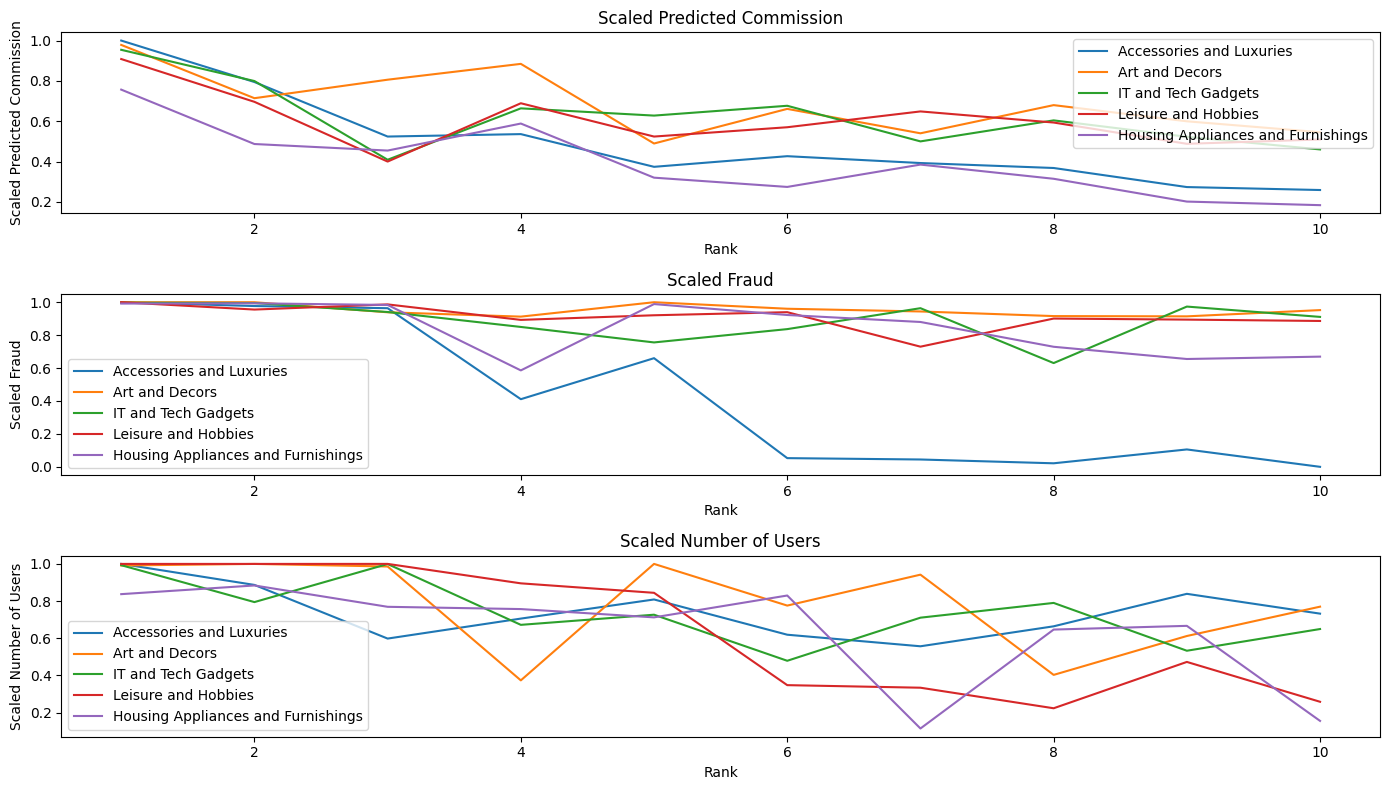

In [23]:
# List of the businesses
studied_businesses = [
    "Accessories and Luxuries",
    "Art and Decors",
    "IT and Tech Gadgets",
    "Leisure and Hobbies",
    "Housing Appliances and Furnishings"
]

# Function to get top 10 by rank_score for each business
def get_top_10_by_business(final_df, business):
    return (final_df
            .filter(F.col('business') == business)
            .orderBy(F.col('rank_score').desc())
            .limit(10))

# Collect the top 10 merchants for each business
top_10_dfs = [get_top_10_by_business(final_df, business) for business in studied_businesses]

# Union all the top 10 DataFrames
top_10_df = top_10_dfs[0]
for df in top_10_dfs[1:]:
    top_10_df = top_10_df.union(df)

# Convert to Pandas for easier plotting
top_10_pd = top_10_df.toPandas()

# Create a rank column for each business
top_10_pd['rank'] = top_10_pd.groupby('business')['rank_score'].rank(ascending=False)

# Set up the plot
plt.figure(figsize=(14, 8))

# Plot 1: scaled_predicted_commission
plt.subplot(3, 1, 1)
for business in studied_businesses:
    sns.lineplot(
        x='rank', 
        y='scaled_predicted_commission', 
        data=top_10_pd[top_10_pd['business'] == business],
        label=business
    )
plt.title('Scaled Predicted Commission')
plt.xlabel('Rank')
plt.ylabel('Scaled Predicted Commission')

# Plot 2: scaled_fraud
plt.subplot(3, 1, 2)
for business in studied_businesses:
    sns.lineplot(
        x='rank', 
        y='scaled_fraud', 
        data=top_10_pd[top_10_pd['business'] == business],
        label=business
    )
plt.title('Scaled Fraud')
plt.xlabel('Rank')
plt.ylabel('Scaled Fraud')

# Plot 3: scaled_num_user
plt.subplot(3, 1, 3)
for business in studied_businesses:
    sns.lineplot(
        x='rank', 
        y='scaled_num_user', 
        data=top_10_pd[top_10_pd['business'] == business],
        label=business
    )
plt.title('Scaled Number of Users')
plt.xlabel('Rank')
plt.ylabel('Scaled Number of Users')

# Display the plots
plt.tight_layout()
plt.show()

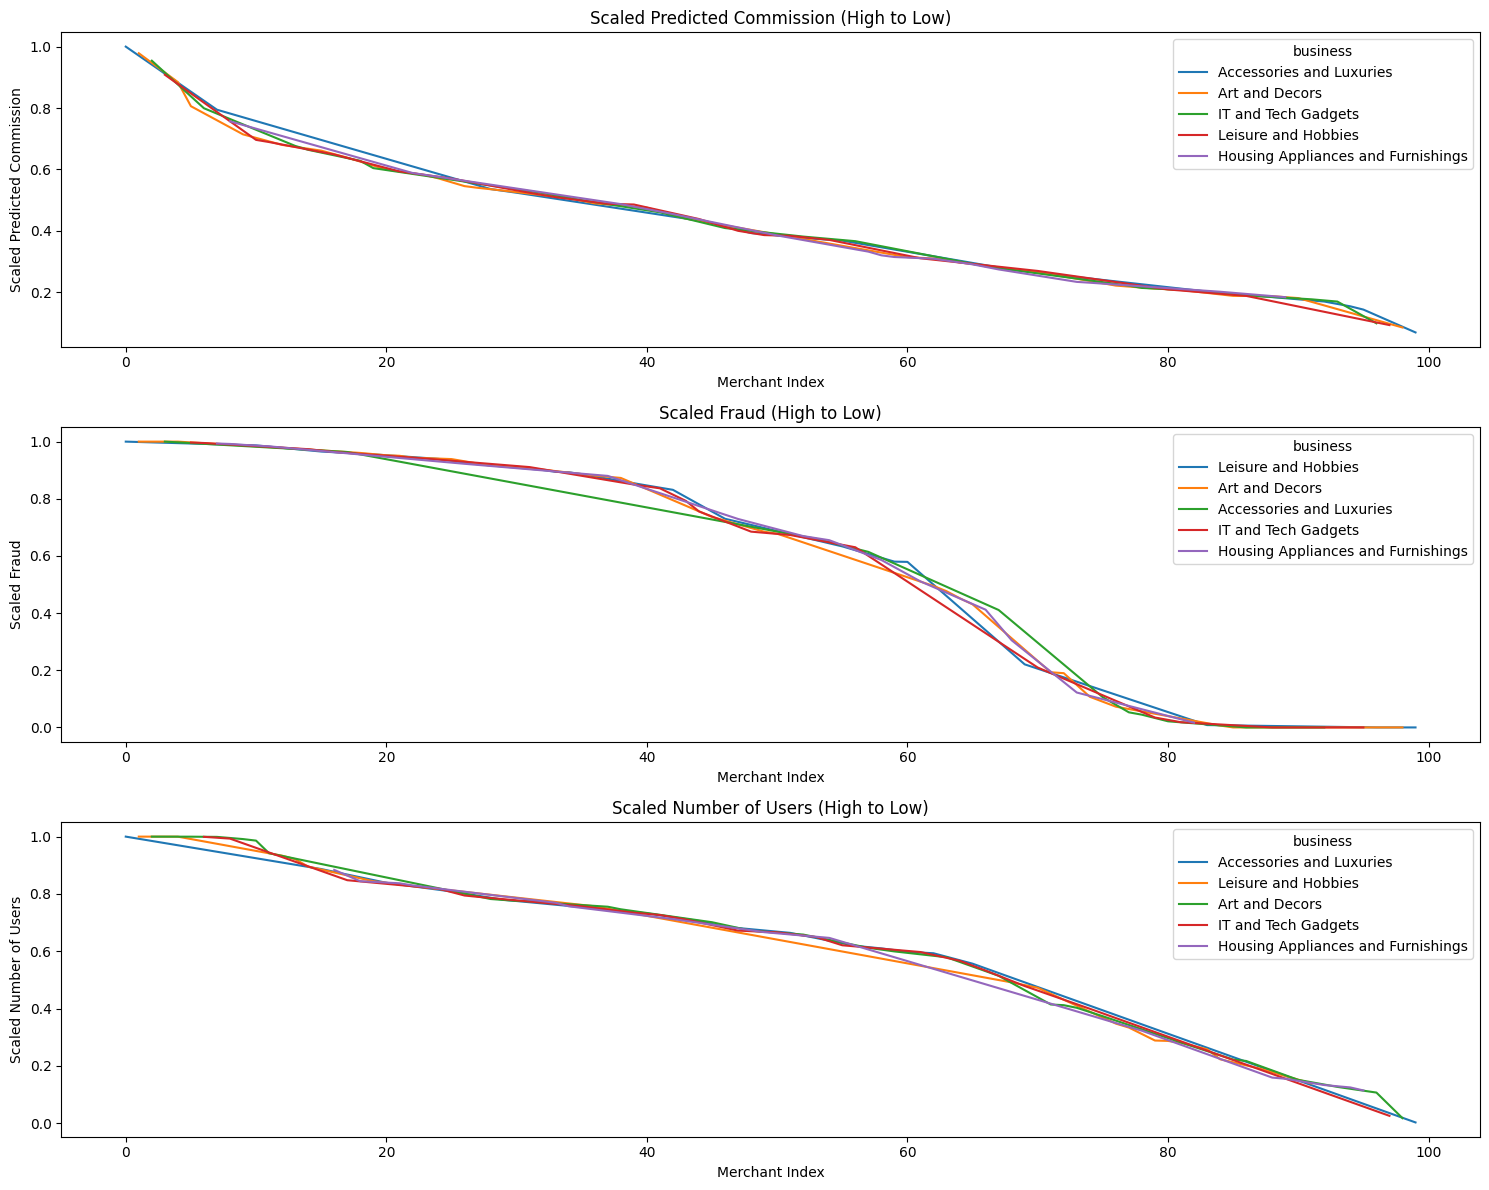

In [24]:
# Define the number of merchants to select for each business
top_counts = {
    "Housing Appliances and Furnishings": 15,
    "Art and Decors": 30,
    "IT and Tech Gadgets": 20,
    "Accessories and Luxuries": 15,
    "Leisure and Hobbies": 20
}

# Function to get top N by rank_score for each business
def get_top_n_by_business(final_df, business, n):
    return (final_df
            .filter(F.col('business') == business)
            .orderBy(F.col('rank_score').desc())
            .limit(n))

# Collect the top merchants for each business
top_dfs = [get_top_n_by_business(final_df, business, count) for business, count in top_counts.items()]

# Union all the top DataFrames into one DataFrame
top_merchants_df = top_dfs[0]
for df in top_dfs[1:]:
    top_merchants_df = top_merchants_df.union(df)

# Convert to Pandas for easier plotting
top_merchants_pd = top_merchants_df.toPandas()

# Now create the three plots without rank, based on the sorted values of the three features

# Sort the DataFrame by each feature for plotting
sorted_by_commission = top_merchants_pd.sort_values(by='scaled_predicted_commission', ascending=False)
sorted_by_fraud = top_merchants_pd.sort_values(by='scaled_fraud', ascending=False)
sorted_by_num_user = top_merchants_pd.sort_values(by='scaled_num_user', ascending=False)

# Set up the figure for 3 plots
plt.figure(figsize=(15, 12))

# Plot 1: scaled_predicted_commission
plt.subplot(3, 1, 1)
sns.lineplot(
    x=range(len(sorted_by_commission)), 
    y='scaled_predicted_commission', 
    hue='business', 
    data=sorted_by_commission,
    palette="tab10"
)
plt.title('Scaled Predicted Commission (High to Low)')
plt.xlabel('Merchant Index')
plt.ylabel('Scaled Predicted Commission')

# Plot 2: scaled_fraud
plt.subplot(3, 1, 2)
sns.lineplot(
    x=range(len(sorted_by_fraud)), 
    y='scaled_fraud', 
    hue='business', 
    data=sorted_by_fraud,
    palette="tab10"
)
plt.title('Scaled Fraud (High to Low)')
plt.xlabel('Merchant Index')
plt.ylabel('Scaled Fraud')

# Plot 3: scaled_num_user
plt.subplot(3, 1, 3)
sns.lineplot(
    x=range(len(sorted_by_num_user)), 
    y='scaled_num_user', 
    hue='business', 
    data=sorted_by_num_user,
    palette="tab10"
)
plt.title('Scaled Number of Users (High to Low)')
plt.xlabel('Merchant Index')
plt.ylabel('Scaled Number of Users')

# Adjust layout and display
plt.tight_layout()
plt.show()